# C3: DataLoader Performance (Varying num_workers)

Task: In this component, we investigate the effect of the DataLoader's num_workers parameter on training throughput. The num_workers setting controls how many parallel worker processes load data. We will compare num_workers values {0, 2, 4, 8} (while keeping batch size = 32 and other hyperparameters fixed) and measure the average epoch time and average data loading time for each setting. This helps identify the optimal number of workers for our workload.

Approach: For each num_workers setting, we re-run the training for 5 epochs (using the same dataset and model configuration) and record:

- The average epoch time (wall-clock time per epoch, averaged over the 5 epochs).

- The average data loading time per epoch (averaged over 5 epochs).

We reuse our timing instrumentation from C2 to collect these metrics. We will reset/reload the dataset and model for each run to ensure a fair comparison. (In practice, one could use the same tokenized data for all runs; here we focus on timing differences.)

In [ ]:
import numpy as np

# Initialize W&B for DataLoader Performance
wandb.init(
    project="hpml-hw2-llm",
    name="C3_dataloader_performance",
    group="C3_experiments",
    config={
        "model_name": model_name,
        "batch_size": 32,
        "lr": 1e-4,
        "epochs": 5,
        "optimizer": "AdamW",
        "device": str(device),
        "compile_mode": False})


worker_settings = [0, 2, 4, 8]
results = []  # to store (num_workers, avg_epoch_time, avg_data_time)
for w in worker_settings:
    # Configure DataLoader with num_workers = w
    train_loader_w = DataLoader(train_ds, batch_size=32, shuffle=True, collate_fn=collate_fn, num_workers=w)

    # Reinitialize model for each setting to avoid any effects of previous training
    model = DistilBertForSequenceClassification.from_pretrained(model_name, num_labels=2).to(device)
    optimizer = optim.AdamW(model.parameters(), lr=1e-4)

    epoch_times = []
    data_times = []
    for epoch in range(1, epochs+1):
        model.train()
        data_time = 0.0
        compute_time = 0.0
        batch_end_time = time.time()
        epoch_start_time = time.time()
        for batch in train_loader_w:
            # Data loading timing
            data_start_time = time.time()
            data_time += data_start_time - batch_end_time

            # Forward and backward pass timing
            batch = {k: v.to(device) for k, v in batch.items()}
            compute_start_time = time.time()
            optimizer.zero_grad()
            outputs = model(**batch)
            loss = outputs.loss
            loss.backward()
            optimizer.step()
            if device.type == "cuda":
                torch.cuda.synchronize()
            compute_end_time = time.time()

            compute_time += compute_end_time - compute_start_time
            batch_end_time = compute_end_time
        epoch_end_time = time.time()
        epoch_times.append(epoch_end_time - epoch_start_time)
        data_times.append(data_time)
    # Calculate average times over 5 epochs for this num_workers setting
    avg_epoch = np.mean(epoch_times)
    avg_data = np.mean(data_times)
    results.append((w, avg_epoch, avg_data))
    print(f"Done num_workers={w}: Avg Epoch Time = {avg_epoch:.3f}s, Avg Data Time = {avg_data:.3f}s")

    # Log results to W&B per worker setting
    wandb.log({
        "num_workers": w,
        "avg_epoch_time": avg_epoch,
        "avg_data_time": avg_data})


# Convert results into W&B Table (for visualization)
table = wandb.Table(columns=["num_workers", "avg_epoch_time", "avg_data_time"])
for w, epoch_t, data_t in results:
    table.add_data(w, epoch_t, data_t)

wandb.log({"dataloader_performance": table})


# Finish W&B run
wandb.finish()
print("Finished C3 DataLoader Performance experiment and logged results to W&B.")

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
You're using a DistilBertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Done num_workers=0: Avg Epoch Time = 121.135s, Avg Data Time = 9.096s


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Done num_workers=2: Avg Epoch Time = 114.001s, Avg Data Time = 1.820s


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Done num_workers=4: Avg Epoch Time = 114.025s, Avg Data Time = 1.857s


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Done num_workers=8: Avg Epoch Time = 114.153s, Avg Data Time = 1.963s


avg_data_time,█▁▁▁
avg_epoch_time,█▁▁▁
num_workers,▁▃▅█
avg_data_time,1.96266
avg_epoch_time,114.15325
num_workers,8


Finished C3 DataLoader Performance experiment and logged results to W&B.


# Experiment Tracking (Weights & Biases) link of W&B run page.

- View run C3_dataloader_performance at: https://wandb.ai/mah3i-tabesh500-mahdi-saleh-tabesh/hpml-hw2-llm/runs/rdxo9rzi
- View project at: https://wandb.ai/mah3i-tabesh500-mahdi-saleh-tabesh/hpml-hw2-llm
- Synced 5 W&B file(s), 1 media file(s), 2 artifact file(s) and 0 other file(s)
- Find logs at: ./wandb/run-20251019_171853-rdxo9rzi/logs


# Table T3: Effect of num_workers on training time (batch size = 32)

In [ ]:
import pandas as pd

# Convert results to a DataFrame
batch_size = 32
t3_df = pd.DataFrame(results, columns=["num_workers", "Avg Epoch Time (s)", "Avg Data Time (s)"])
t3_df["Batch Size"] = batch_size

print("\nTable T3: DataLoader Performance Results\n")
print(t3_df)


Table T3: DataLoader Performance Results

   num_workers  Avg Epoch Time (s)  Avg Data Time (s)  Batch Size
0            0          121.134538           9.096030          32
1            2          114.001354           1.819872          32
2            4          114.025084           1.857165          32
3            8          114.153252           1.962660          32


## Figure F3: Average epoch time vs. number of DataLoader worker processes.

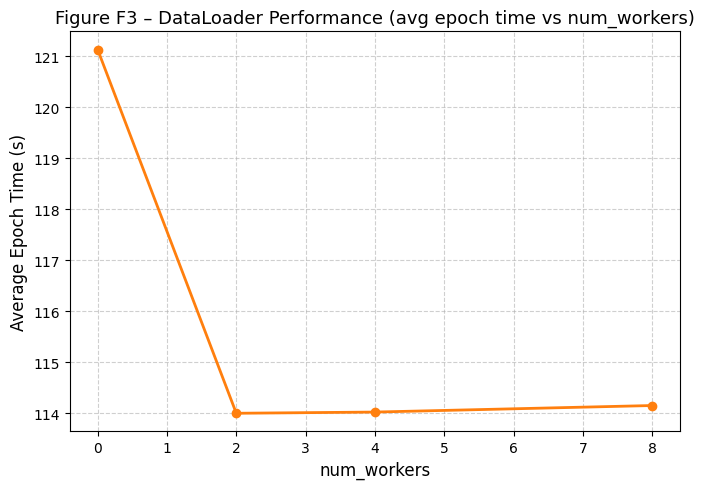

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(7,5))
plt.plot(t3_df["num_workers"], t3_df["Avg Epoch Time (s)"], marker='o', color='C1', linewidth=2)
plt.xlabel("num_workers", fontsize=12)
plt.ylabel("Average Epoch Time (s)", fontsize=12)
plt.title("Figure F3 – DataLoader Performance (avg epoch time vs num_workers)", fontsize=13)
plt.grid(True, linestyle="--", alpha=0.6)
plt.tight_layout()
plt.show()

# One-sentence conclusion: Which num_workers is optimal and why?
- Conclusion: The optimal num_workers is 2 or 4, as both significantly reduce data-loading overhead and total epoch time compared to 0, while higher values (8) offer no additional speedup due to multiprocessing overhead.

## C4: PyTorch Profiler (15 pts)

In this section, we use **`torch.profiler`** to analyze the runtime performance.  
Two configurations are tested:
- `num_workers = 1`
- `num_workers = 4` (optimal value found in C3)

The profiler captures both **CPU** and **CUDA** activities during one training epoch to determine how much time is spent in:
- Data loading  
- Forward pass  
- Backward pass  
- Optimizer step  

At the end of each run, the script prints:
1. A breakdown of phase percentages (**Table T4**).  
2. The top operations ranked by `self_cpu_time_total` (**Figure F4**) for each configuration.

In [ ]:
import torch
import time

from torch.utils.data import DataLoader

# Initialize W&B for profiling experiment
wandb.init(
    project="hpml-hw2-llm",
    name="C4_profiler_breakdown",
    group="C4_experiments",
    config={
        "model_name": model_name,
        "batch_size": 32,
        "lr": 1e-4,
        "epochs": 1,
        "optimizer": "AdamW",
        "device": "cuda",
        "num_workers_tested": [1, 4],
        "compile_mode": False
    })

# Use optimal num_workers from C3
best_num_workers = 4
worker_settings = [1, best_num_workers]

# Prepare table to store percentage time breakdown for each setting
t4_results = []

for nw in worker_settings:
    # Set up DataLoader with specified num_workers
    train_loader = DataLoader(train_ds, batch_size=32, shuffle=True, collate_fn=collate_fn, num_workers=nw)
    # Reinitialize model and optimizer for each run (fresh state)
    model = DistilBertForSequenceClassification.from_pretrained(model_name, num_labels=2).to('cuda')
    optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4)
    # Profiling for a single epoch
    data_time = 0.0
    forward_time = 0.0
    backward_time = 0.0
    optim_time = 0.0
    total_start_time = time.time()
    batch_end_time = total_start_time
    # Use PyTorch Profiler to capture operator-level stats
    with torch.profiler.profile(activities=[torch.profiler.ProfilerActivity.CPU, torch.profiler.ProfilerActivity.CUDA]) as prof:
        model.train()
        for batch in train_loader:
            # Measure data loading time (time waiting for batch to be ready)
            current_time = time.time()
            data_time += current_time - batch_end_time
            # Move batch to GPU
            batch = {k: v.to('cuda') for k, v in batch.items()}
            # Forward pass
            fwd_start = time.time()
            outputs = model(**batch)
            loss = outputs.loss
            torch.cuda.synchronize()  # ensure forward pass finished
            fwd_end = time.time()
            # Backward pass
            loss.backward()
            torch.cuda.synchronize()
            bwd_end = time.time()
            # Optimizer step
            optimizer.step()
            torch.cuda.synchronize()
            opt_end = time.time()
            # Accumulate times for each phase
            forward_time += (fwd_end - fwd_start)
            backward_time += (bwd_end - fwd_end)
            optim_time += (opt_end - bwd_end)
            # Mark end of batch compute for next iteration
            batch_end_time = opt_end
        # end of epoch (train_loader exhausted for one epoch)
    total_end_time = time.time()
    epoch_total_time = total_end_time - total_start_time
    # Calculate percentage breakdown
    data_pct = (data_time / epoch_total_time) * 100.0
    fwd_pct = (forward_time / epoch_total_time) * 100.0
    bwd_pct = (backward_time / epoch_total_time) * 100.0
    opt_pct = (optim_time / epoch_total_time) * 100.0
    t4_results.append((f"nw={nw}", round(data_pct,1), round(fwd_pct,1), round(bwd_pct,1), round(opt_pct,1)))
    print(f"Completed profiling for num_workers={nw}: Data {data_pct:.1f}%, Forward {fwd_pct:.1f}%, Backward {bwd_pct:.1f}%, Optimizer {opt_pct:.1f}%")
    # Output top operations by self CPU time from profiler
    print(f"Top ops (by self CPU time) for num_workers={nw}:")
    print(prof.key_averages().table(sort_by="self_cpu_time_total", row_limit=10))
    print("-" * 80)

    # --- Log to W&B ---
    wandb.log({
        "num_workers": nw,
        "data_pct": data_pct,
        "forward_pct": fwd_pct,
        "backward_pct": bwd_pct,
        "optimizer_pct": opt_pct
    })

# Log results as a W&B Table (for Figure F4)
table = wandb.Table(columns=["num_workers", "Data %", "Forward %", "Backward %", "Optimizer %"])
for nw, d, f, b, o in t4_results:
    table.add_data(nw, d, f, b, o)
wandb.log({"Stage Breakdown (Figure F4)": table})

wandb.finish()
print("✅ Finished C4 Profiler experiment and logged to W&B.")

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Completed profiling for num_workers=1: Data 1.2%, Forward 25.9%, Backward 52.7%, Optimizer 3.2%
Top ops (by self CPU time) for num_workers=1:
-------------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                                                   Name    Self CPU %      Self CPU   CPU total %     CPU total  CPU time avg     Self CUDA   Self CUDA %    CUDA total  CUDA time avg    # of Calls  
-------------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                                  cudaDeviceSynchronize        80.97%       90.653s        80.97%       90.653s      38.625ms      35.881ms         0.03%      35.881ms      15.288us          2347  
                                       cudaLaunchKernel         2

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Completed profiling for num_workers=4: Data 1.7%, Forward 25.9%, Backward 52.7%, Optimizer 3.2%
Top ops (by self CPU time) for num_workers=4:
-------------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                                                   Name    Self CPU %      Self CPU   CPU total %     CPU total  CPU time avg     Self CUDA   Self CUDA %    CUDA total  CUDA time avg    # of Calls  
-------------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                                  cudaDeviceSynchronize        80.08%       90.014s        80.08%       90.014s      38.353ms       0.000us         0.00%       0.000us       0.000us          2347  
                                       cudaLaunchKernel         2

backward_pct,▁█
data_pct,▁█
forward_pct,█▁
num_workers,▁█
optimizer_pct,▁█
backward_pct,52.68817
data_pct,1.74904
forward_pct,25.91506
num_workers,4
optimizer_pct,3.23118


✅ Finished C4 Profiler experiment and logged to W&B.


# Experiment Tracking (Weights & Biases) link of W&B run page.
- View run C4_profiler_breakdown at: https://wandb.ai/mah3i-tabesh500-mahdi-saleh-tabesh/hpml-hw2-llm/runs/dr2zw6w4
- View project at: https://wandb.ai/mah3i-tabesh500-mahdi-saleh-tabesh/hpml-hw2-llm
- Synced 5 W&B file(s), 1 media file(s), 2 artifact file(s) and 0 other file(s)
- Find logs at: ./wandb/run-20251019_175737-dr2zw6w4/logs

In [ ]:
# Create DataFrame for Table T4
import pandas as pd
t4_df = pd.DataFrame(t4_results, columns=["Setting", "Data (%)", "Forward (%)", "Backward (%)", "Optimizer (%)"])
print("\nTable T4: Time breakdown per phase (data vs forward vs backward vs optimizer)\n")
print(t4_df)


Table T4: Time breakdown per phase (data vs forward vs backward vs optimizer)

  Setting  Data (%)  Forward (%)  Backward (%)  Optimizer (%)
0    nw=1       1.2         25.9          52.7            3.2
1    nw=4       1.7         25.9          52.7            3.2


## **Figure F4 – PyTorch Profiler Summary**
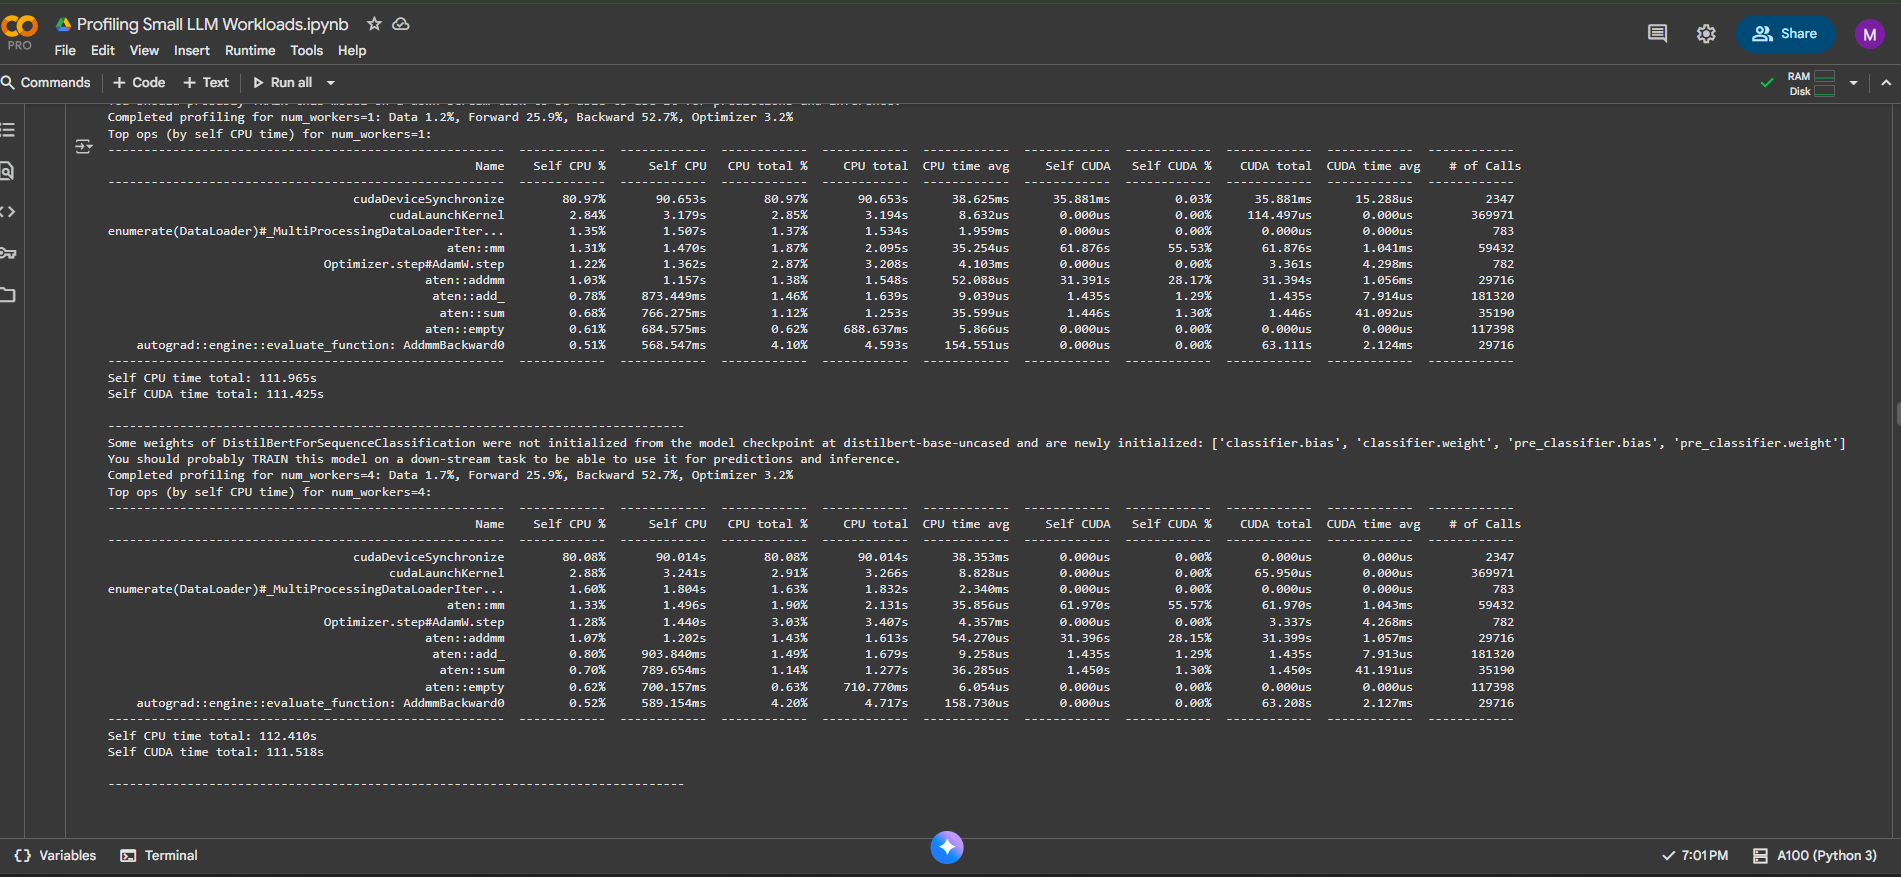